In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import VariationalAutoencoder, Autoencoder
from afqinsight.nn.utils import reconstruction_loss

/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#This notebook runs a simple autoencoder on just first tract of each AFQ dataset sample, and visualizes the difference the number of latent bottleneck layers has on the best loss. 

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100

File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
def train_multiple_latent_dimensions(train_data, val_data, epochs=100, lr=0.001, sigma=0.03):
    latent_dims = [2, 4, 8, 16, 32, 64, 100]
    results = []

    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim}")

        # Initialize a new autoencoder for each latent dimension
        # model = Autoencoder(input_dim=100, latent_dim=latent_dim).to(device)
        model = Autoencoder(input_shape=100, latent_dims=latent_dim, dropout=0.2).to(device)
        # model = VariationalAutoencoder(input_shape=100, latent_dims=latent_dim, dropout=0.2).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

        train_rmse_per_epoch = []
        val_rmse_per_epoch = []
        best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
        best_model_state = None     # Save the best model state

        for epoch in range(epochs):
            # Training
            model.train()
            running_loss = 0
            running_rmse = 0
            items = 0

            for x, _ in train_data:  # x shape: (batch_size, 48, 100)
                batch_size = x.size(0)
                tract_data = x[:, 0, :].to(device)  # Shape: (batch_size, 100)

                opt.zero_grad()
                x_hat = model(tract_data)

                loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
                batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                loss.backward()
                opt.step()

                items += tract_data.size(0)
                running_loss += loss.item()
                running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

            scheduler.step(running_loss / items)
            avg_train_rmse = running_rmse / items
            train_rmse_per_epoch.append(avg_train_rmse)

            # Validation
            model.eval()
            val_rmse = 0
            val_items = 0

            with torch.no_grad():
                for x, _ in val_data:
                    tract_data = x[:, 0, :].to(device)
                    x_hat = model(tract_data)
                    batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                    val_items += tract_data.size(0)
                    val_rmse += batch_val_rmse.item() * tract_data.size(0)

            avg_val_rmse = val_rmse / val_items
            val_rmse_per_epoch.append(avg_val_rmse)

            # Check and save the best model state if current validation loss is lower
            if avg_val_rmse < best_val_loss:
                best_val_loss = avg_val_rmse
                best_model_state = model.state_dict()

            print(f"Latent Dim {latent_dim} - Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "train_rmse_per_epoch": train_rmse_per_epoch,
            "val_rmse_per_epoch": val_rmse_per_epoch,
            "best_val_loss": best_val_loss,
            "best_model_state": best_model_state  # Optional: Save checkpoint for later use
        })

    return results

In [6]:
results = train_multiple_latent_dimensions(train_loader, val_loader)

Training Autoencoder with Latent Dimension: 2
Latent Dim 2 - Epoch 1, Train RMSE: 0.3812, Val RMSE: 0.2539
Latent Dim 2 - Epoch 2, Train RMSE: 0.1739, Val RMSE: 0.0966
Latent Dim 2 - Epoch 3, Train RMSE: 0.0804, Val RMSE: 0.0511
Latent Dim 2 - Epoch 4, Train RMSE: 0.0569, Val RMSE: 0.0456
Latent Dim 2 - Epoch 5, Train RMSE: 0.0538, Val RMSE: 0.0449
Latent Dim 2 - Epoch 6, Train RMSE: 0.0523, Val RMSE: 0.0457
Latent Dim 2 - Epoch 7, Train RMSE: 0.0516, Val RMSE: 0.0449
Latent Dim 2 - Epoch 8, Train RMSE: 0.0502, Val RMSE: 0.0449
Latent Dim 2 - Epoch 9, Train RMSE: 0.0487, Val RMSE: 0.0450
Latent Dim 2 - Epoch 10, Train RMSE: 0.0485, Val RMSE: 0.0446
Latent Dim 2 - Epoch 11, Train RMSE: 0.0481, Val RMSE: 0.0443
Latent Dim 2 - Epoch 12, Train RMSE: 0.0479, Val RMSE: 0.0448
Latent Dim 2 - Epoch 13, Train RMSE: 0.0466, Val RMSE: 0.0438
Latent Dim 2 - Epoch 14, Train RMSE: 0.0463, Val RMSE: 0.0436
Latent Dim 2 - Epoch 15, Train RMSE: 0.0459, Val RMSE: 0.0428
Latent Dim 2 - Epoch 16, Train RM

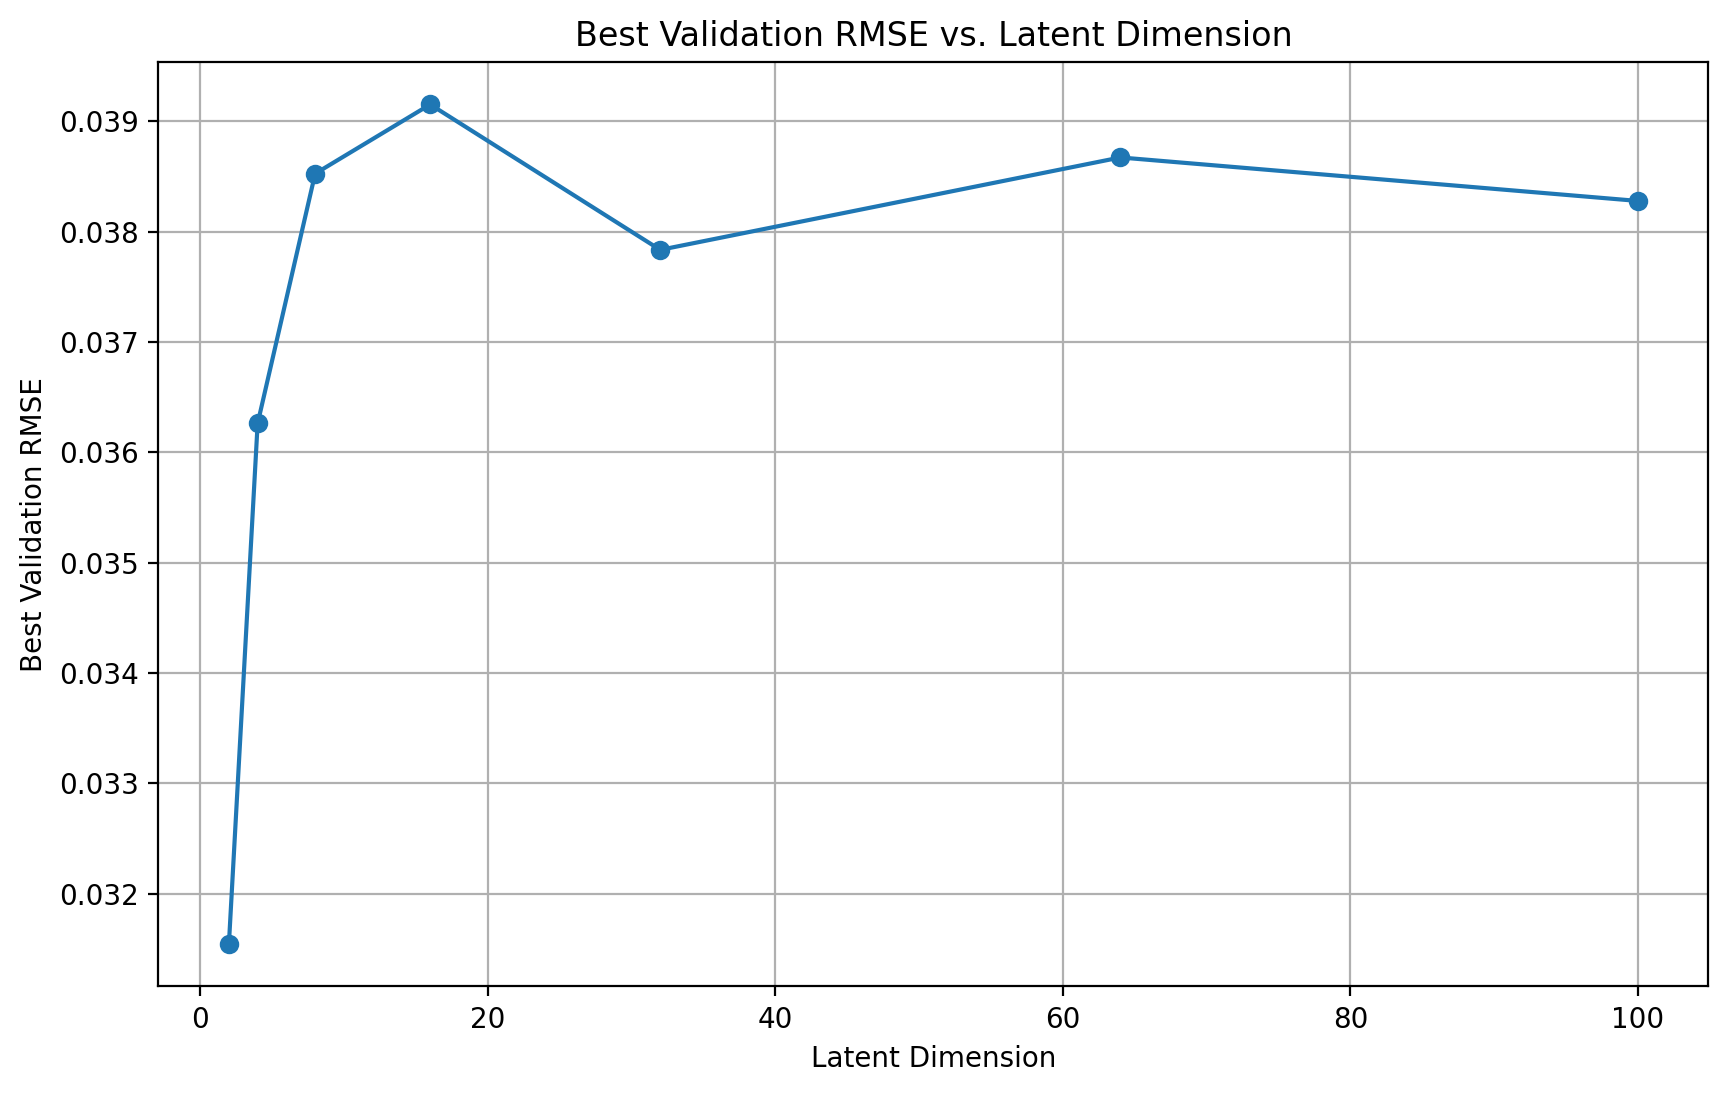

In [7]:
latent_dims = [result["latent_dim"] for result in results]
best_val_losses = [result["best_val_loss"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Latent Dimension")
plt.grid()
plt.show()

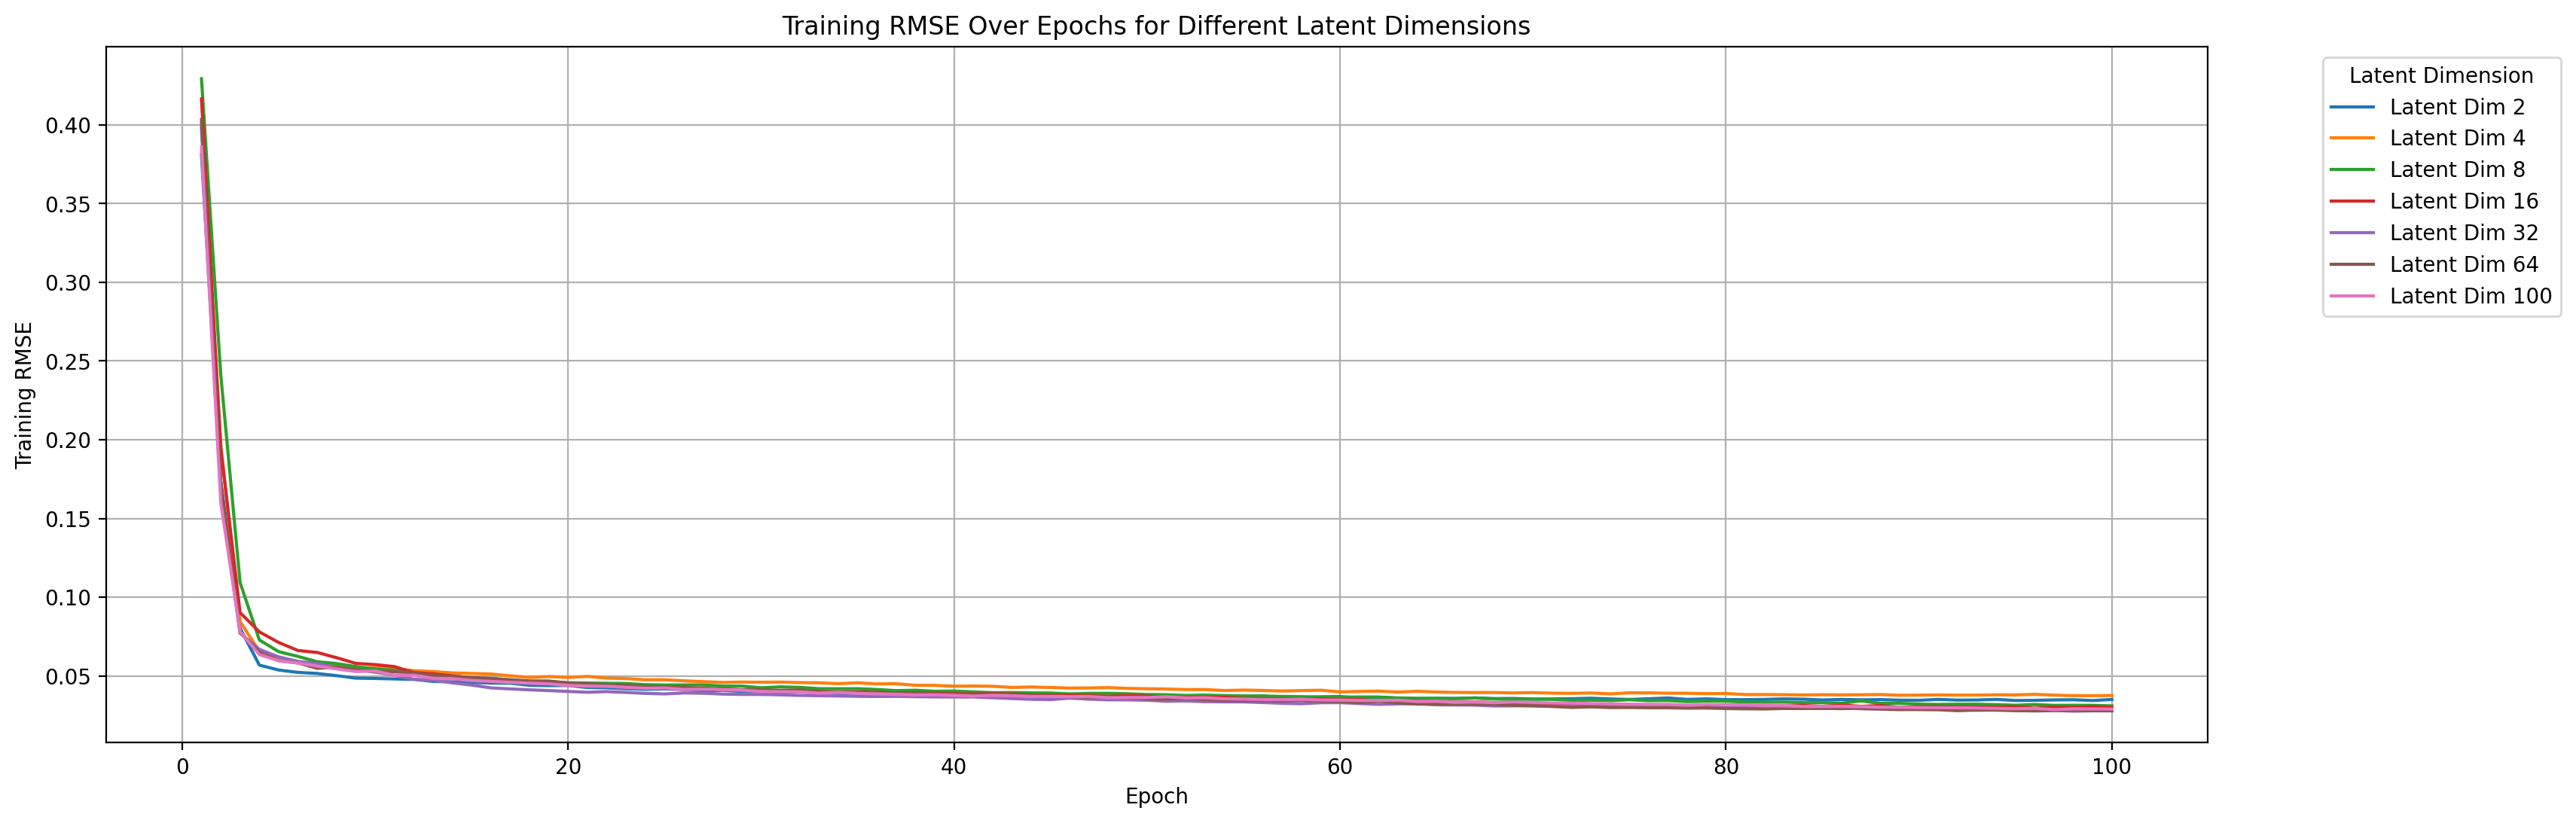

In [8]:
latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#plot 1, train rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results: 
    plt.plot(
        range(1, len(result["train_rmse_per_epoch"]) + 1),
        result["train_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}",  
    )
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.title("Training RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

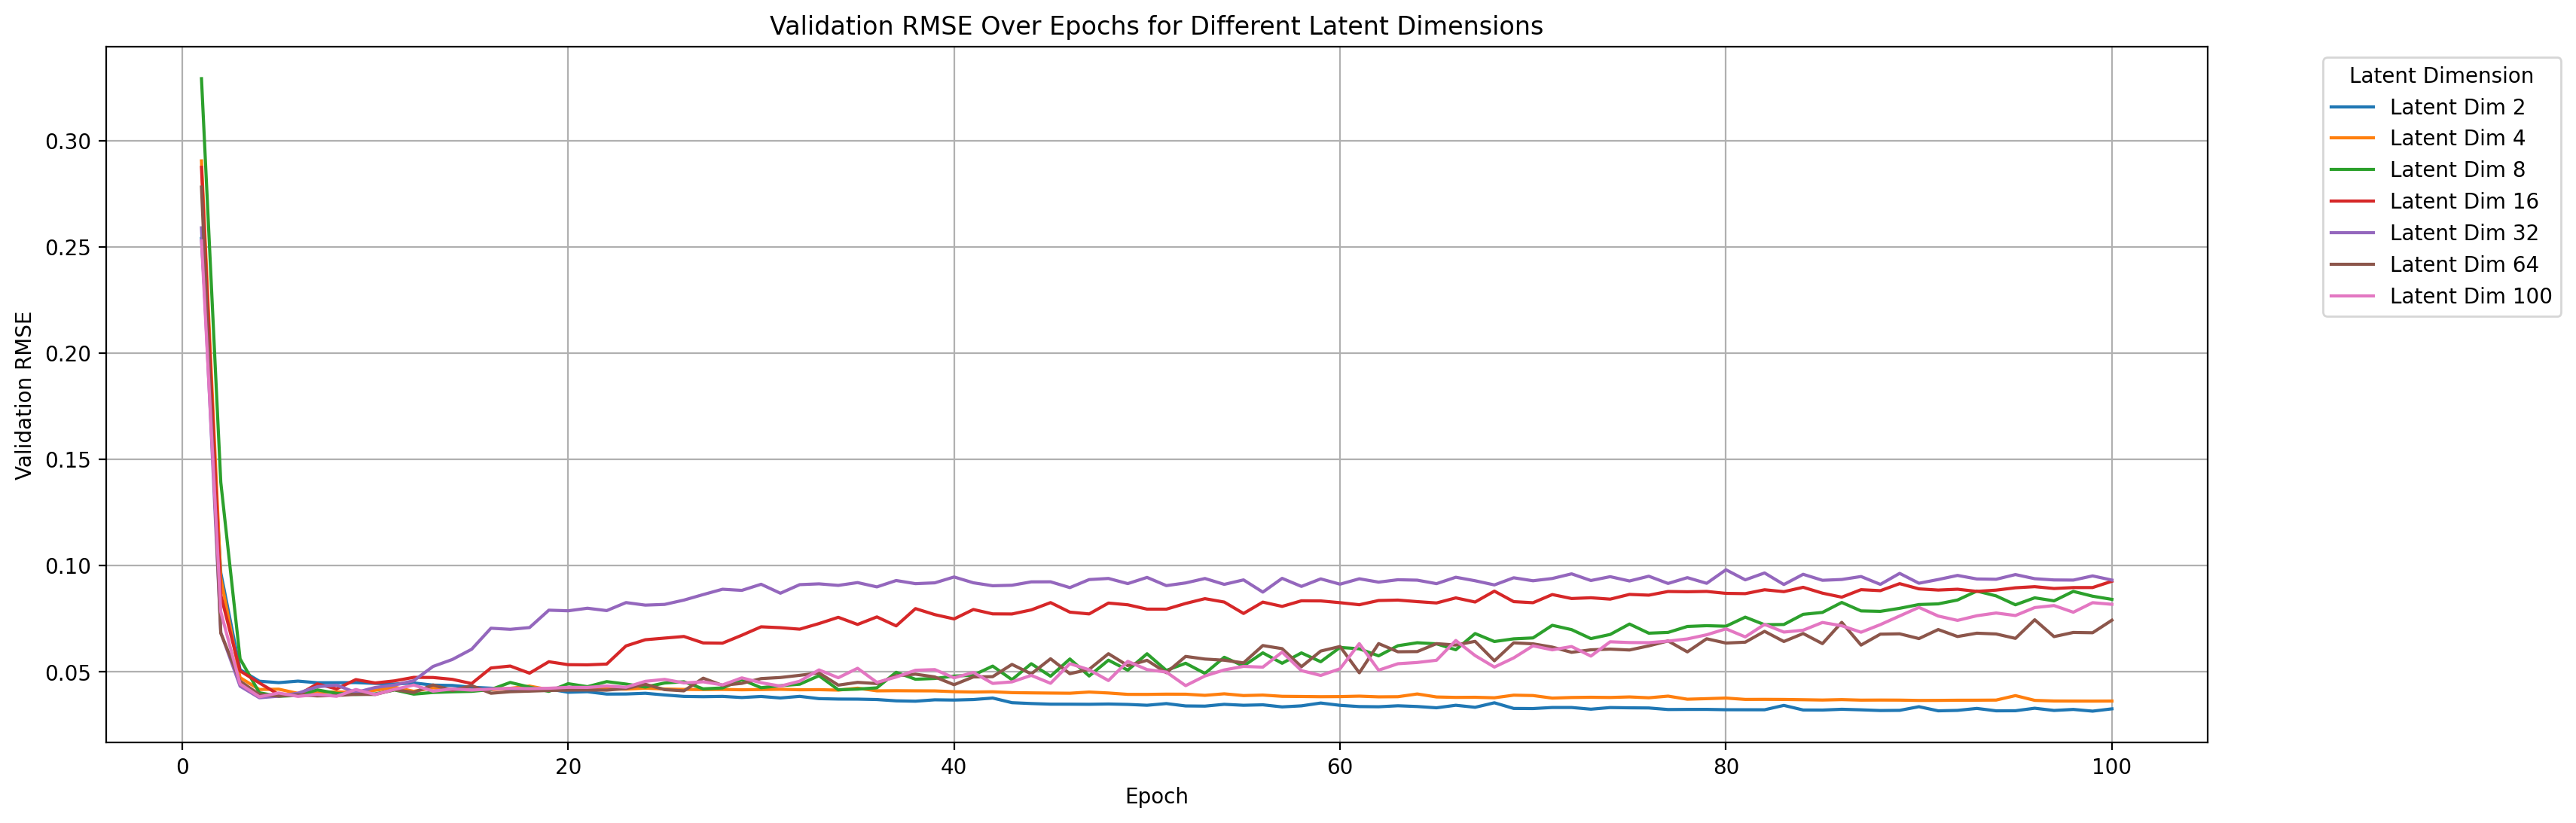

In [9]:
#plot 1, val rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results:  
    plt.plot(
        range(1, len(result["val_rmse_per_epoch"]) + 1),
        result["val_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}", 
    )
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()